# Age of Empires II Match Analysis

This notebook analyzes match data from Age of Empires II to discover patterns in game outcomes based on civilizations, map types, match duration, and player positions.

The dataset contains information about matches including:
- Match details (ID, map, duration)
- Player civilizations
- Player starting positions
- ELO ratings
- Match outcomes

We'll explore how these factors influence win rates and identify patterns to help players make better strategic choices.

In [6]:
# Let's do some clustering to find patterns
# Player position analysis - create heatmap of starting positions
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


# load the data
df = pd.read_csv('aoe_data.csv')
data = df.copy()

# drop match uid -- not needed for analysis
df = df.drop(columns=['Unnamed: 0'])

## Data Preparation

Above, we import necessary libraries and load the AOE2 match dataset. We've removed unnecessary columns to focus on the relevant match information.

In [7]:
# Create a dataframe for civilization win rates by game duration for clustering
# Group by civilization and game duration category
df['duration_category'] = pd.cut(df['duration'], bins=[0, 1500, 2500, 3500, 7000], labels=['Early', 'Mid', 'Late', 'Very Late'])

# Creating a pivot table for civilization win rates across different game durations
# Fix warnings by setting observed=True
p1_civs = df.groupby(['p1_civ', 'duration_category'], observed=True).agg({'winner': lambda x: sum(x == 1)/len(x) * 100 if len(x) > 0 else 50}).reset_index()
p2_civs = df.groupby(['p2_civ', 'duration_category'], observed=True).agg({'winner': lambda x: sum(x == 2)/len(x) * 100 if len(x) > 0 else 50}).reset_index()

# Rename columns for clarity
p1_civs.columns = ['civilization', 'duration_category', 'win_rate']
p2_civs.columns = ['civilization', 'duration_category', 'win_rate']

# Combine both datasets
all_civs = pd.concat([p1_civs, p2_civs])

# Average win rates by civilization and duration using observed=True to suppress warnings
civ_win_rates = all_civs.groupby(['civilization', 'duration_category'], observed=True)['win_rate'].mean().reset_index()

# Create a pivot table for clustering
heatmap_df = civ_win_rates.pivot(index='civilization', columns='duration_category', values='win_rate')

# Display the data
print(f"We have win rate data for {len(heatmap_df)} civilizations across different game durations")
heatmap_df.sort_values('Very Late', ascending=False).head(2)

We have win rate data for 39 civilizations across different game durations


duration_category,Early,Mid,Late,Very Late
civilization,,,,
Burmese,27.453271,25.129870,29.938272,28.767123
Incas,24.804178,27.210611,24.180735,28.267477


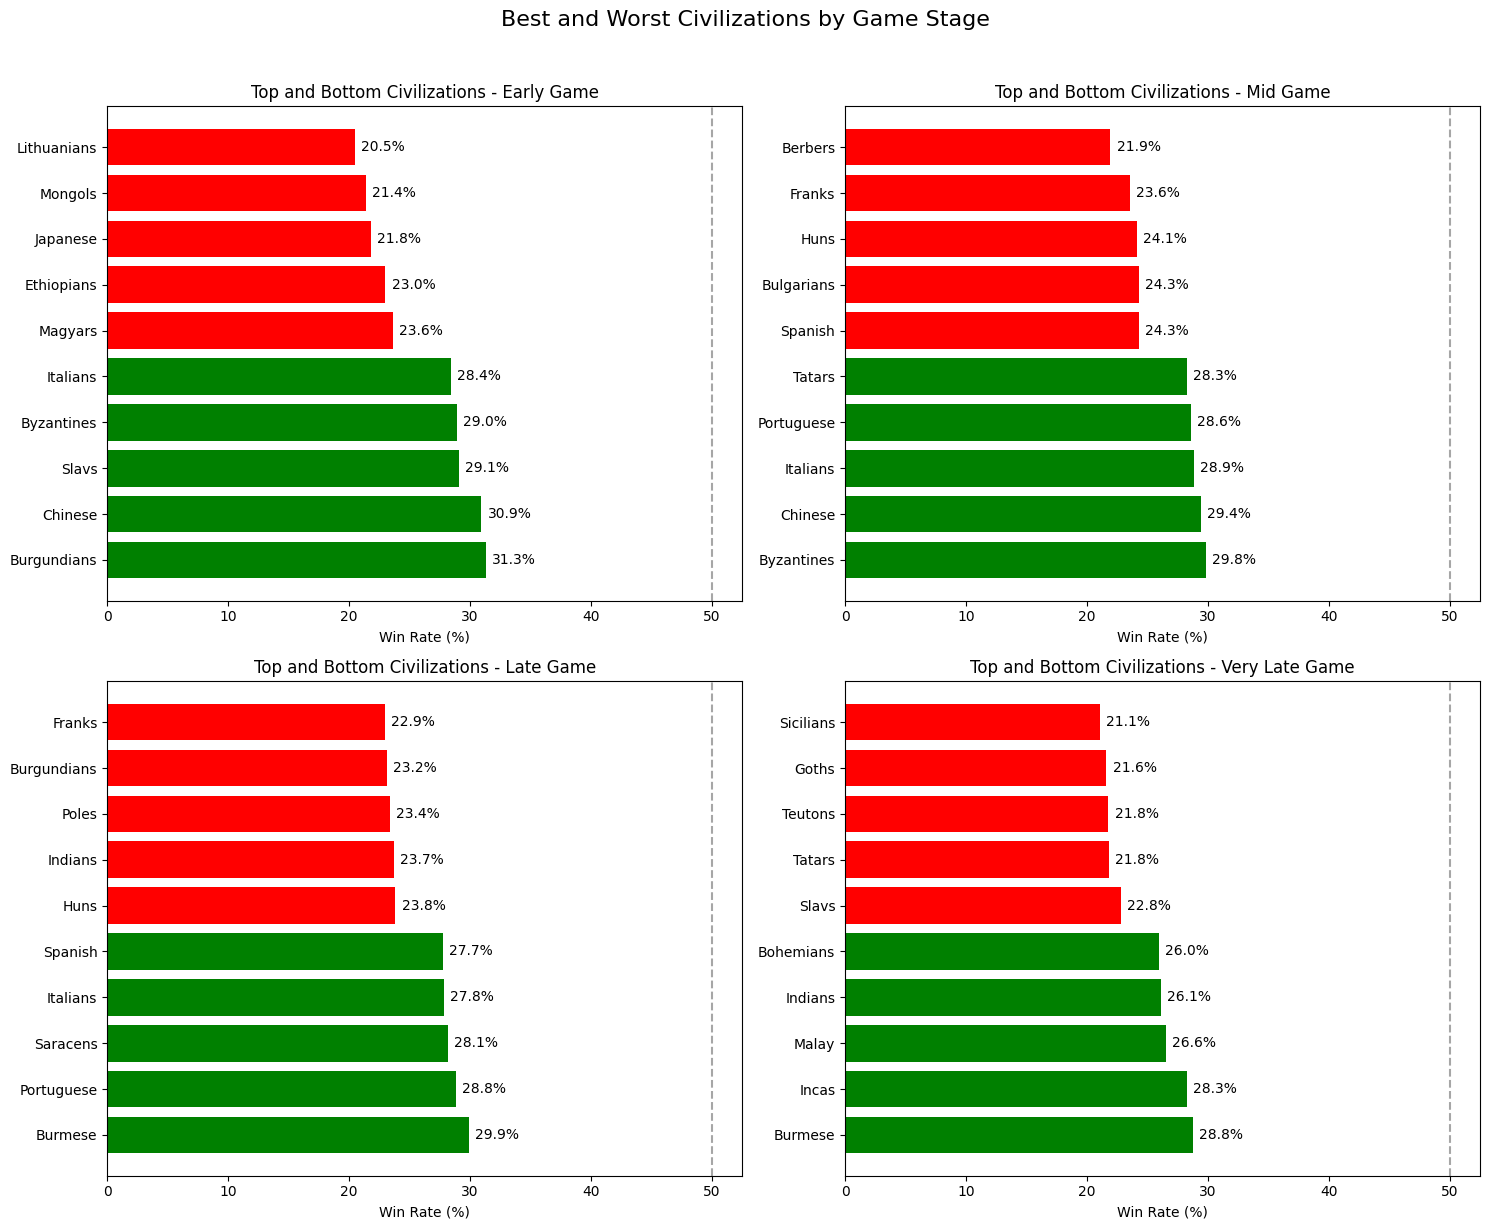

In [8]:
# Create a visualization that shows top and bottom performers for each game stage
plt.figure(figsize=(15, 12))

# For each game stage
for i, stage in enumerate(['Early', 'Mid', 'Late', 'Very Late']):
    plt.subplot(2, 2, i+1)
    
    # Sort the data
    stage_data = heatmap_df[stage].sort_values(ascending=False).dropna()
    
    # Get top and bottom 5
    top_5 = stage_data.head(5)
    bottom_5 = stage_data.tail(5)
    
    # Combine them
    plot_data = pd.concat([top_5, bottom_5])
    
    # Create a color map (green for top, red for bottom)
    colors = ['green']*5 + ['red']*5
    
    # Plot horizontal bar chart
    bars = plt.barh(plot_data.index, plot_data.values, color=colors)
    
    # Add a vertical line at 50% (theoretical balanced win rate)
    plt.axvline(x=50, color='gray', linestyle='--', alpha=0.7)
    
    # Add value labels to the bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{width:.1f}%', ha='left', va='center')
    
    plt.title(f'Top and Bottom Civilizations - {stage} Game')
    plt.xlabel('Win Rate (%)')
    plt.tight_layout()

plt.suptitle('Best and Worst Civilizations by Game Stage', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

In [9]:
# Use PCA to visualize civilization clusters
from sklearn.decomposition import PCA

# Apply clustering with the optimal k from your elbow method (e.g., 4)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Plot the results
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis', 
                     s=100, alpha=0.8, edgecolors='w')

# Add labels for each civilization
for i, civ in enumerate(heatmap_df.index):
    plt.annotate(civ, (pca_result[i, 0], pca_result[i, 1]), 
                fontsize=9, alpha=0.7,
                xytext=(5, 5), textcoords='offset points')

plt.title('Civilization Clusters Based on Win Rates Across Game Stages')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

NameError: name 'scaled_data' is not defined

## Visualization of Civilizations by Cluster

Let's create a 2D visualization of our civilizations to see how they group together and identify any outliers.

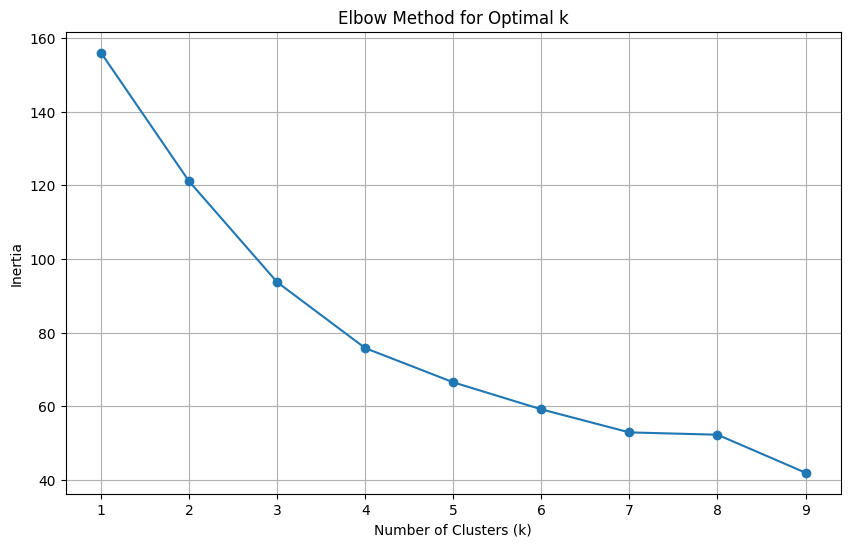

In [ ]:
# Scale the data for clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(heatmap_df.fillna(50))

# Determine optimal number of clusters using the elbow method
inertia = []
k_range = range(1, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

k=3  •  silhouette=0.218
k=4  •  silhouette=0.243

➡  Using k=4 (highest silhouette)

=== Cluster Summary ===
         n_civs  early_avg  mid_avg  late_avg  vlate_avg
cluster                                                 
0             7      26.03    24.86     23.61      25.84
1             8      28.30    28.45     26.98      23.69
2            10      26.14    25.59     27.01      25.86
3            14      24.45    26.08     25.31      23.01

Cluster 0 civs: Berbers, Burgundians, Franks, Huns, Incas, Indians, Poles

Cluster 1 civs: Byzantines, Chinese, Italians, Portuguese, Saracens, Slavs, Tatars, Vietnamese

Cluster 2 civs: Bohemians, Britons, Burmese, Celts, Cumans, Ethiopians, Khmer, Malay, Spanish, Turks

Cluster 3 civs: Aztecs, Bulgarians, Goths, Japanese, Koreans, Lithuanians, Magyars, Malians, Mayans, Mongols, Persians, Sicilians, Teutons, Vikings


<Figure size 1000x500 with 0 Axes>

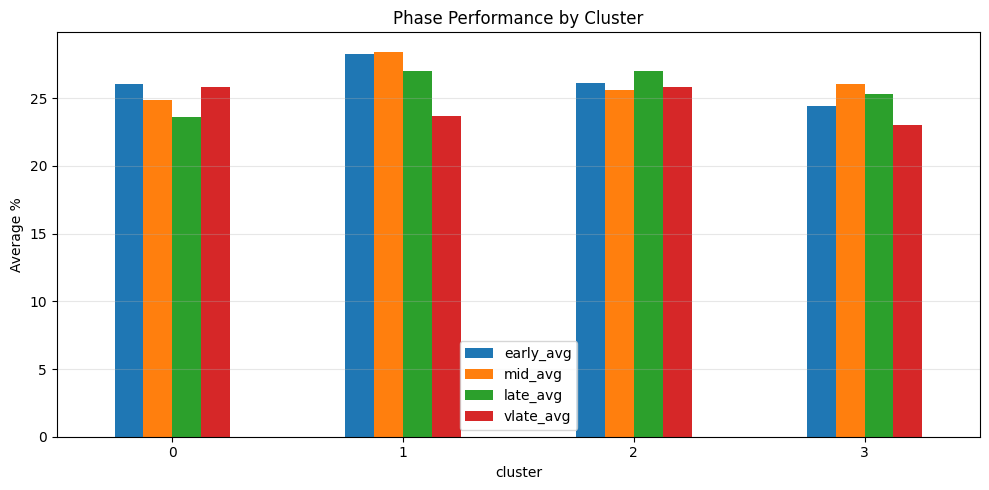

In [ ]:

df_heatmap = heatmap_df.copy().fillna(50)       # simple placeholder; tweak if needed
scaled_X   = StandardScaler().fit_transform(df_heatmap)



best_k, best_score = None, -1
for k in [3, 4]:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    lbl = km.fit_predict(scaled_X)
    score = silhouette_score(scaled_X, lbl)
    print(f"k={k}  •  silhouette={score:.3f}")
    if score > best_score:
        best_k, best_score = k, score

print(f"\n➡  Using k={best_k} (highest silhouette)")


# Fit the KMeans model with the best k
kmeans              = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
df_heatmap['cluster'] = kmeans.fit_predict(scaled_X)


# Add cluster labels to the original dataframe
df = df_heatmap.reset_index()                   # bring 'civilization' out of index

cluster_stats = (df
                 .groupby('cluster')
                 .agg(
                     n_civs      = ('civilization','count'),
                     early_avg   = ('Early','mean'),
                     mid_avg     = ('Mid','mean'),
                     late_avg    = ('Late','mean'),
                     vlate_avg   = ('Very Late','mean'))
                 .round(2))

print("\n=== Cluster Summary ===")
print(cluster_stats)

# list civs per cluster (optional)
for k in sorted(df['cluster'].unique()):
    civ_list = ", ".join(df.loc[df['cluster']==k, 'civilization'])
    print(f"\nCluster {k} civs: {civ_list}")

# Plot the cluster performance
plt.figure(figsize=(10, 5))
cluster_stats[['early_avg','mid_avg','late_avg','vlate_avg']].plot.bar(
    figsize=(10,5), ylabel='Average %', title='Phase Performance by Cluster', rot=0)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()



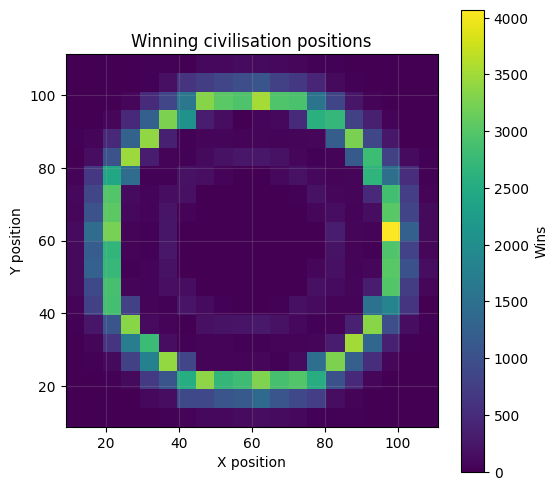

In [ ]:
# isolate the winner civs
data['win_x'] = np.where(data['winner'] == 1, data['p1_xpos'], data['p2_xpos'])
data['win_y'] = np.where(data['winner'] == 1, data['p1_ypos'], data['p2_ypos'])

# drop nans
coords = data[['win_x', 'win_y']].dropna()

# ── 2A. simple 2-D histogram (square heat-map) ───────────────────
plt.figure(figsize=(10,6))
plt.hist2d(coords['win_x'], coords['win_y'],
           bins=20, cmap='viridis')        # tweak bins for resolution
plt.colorbar(label='Wins')
plt.title('Winning civilisation positions')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.gca().set_aspect('equal')              # keep it square
plt.grid(alpha=0.2)
plt.show()
